In [1]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

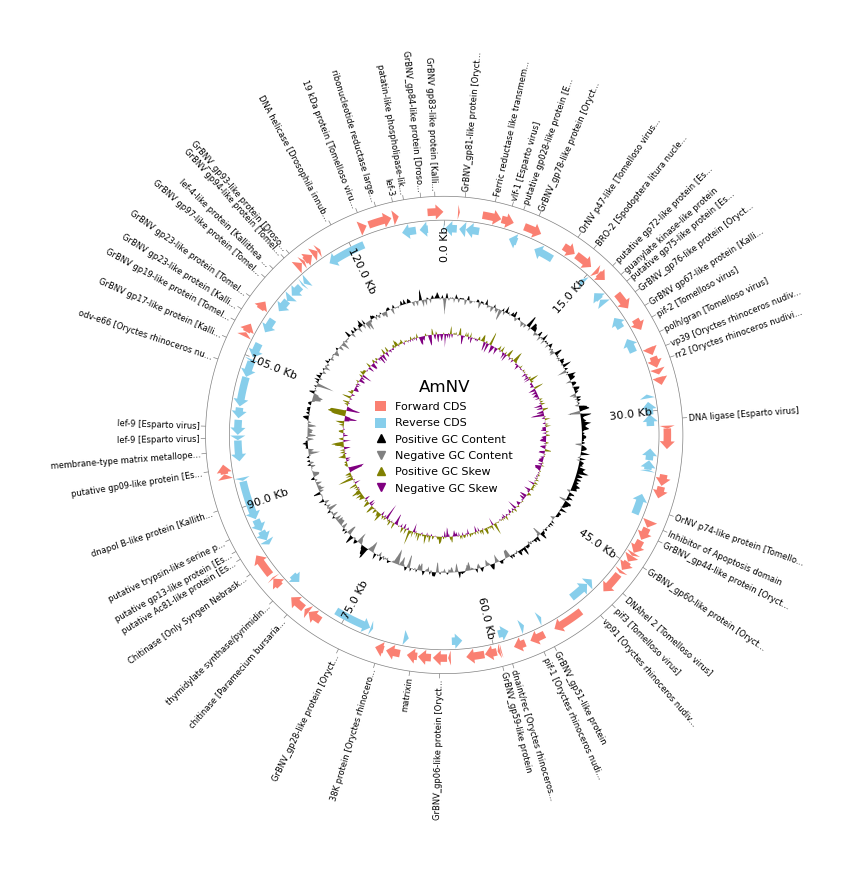

In [2]:
# Load Genbank file
gbk = Genbank("AmNV.gbk")

circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text("AmNV", size=12, r=20)
sector = circos.get_sector(gbk.name)
cds_track = sector.add_track((90, 100))


# Plot xticks & intervals on inner position
cds_track.xticks_by_interval(
    interval=15000,
    outer=False,
    show_bottom_line=True,
    label_formatter=lambda v: f"{v/ 1000:.1f} Kb",
    label_orientation="vertical",
    line_kws=dict(ec="grey"),
)


# Plot Forward CDS, Reverse CDS
f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="salmon", plotstyle="arrow",)

r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="skyblue", plotstyle="arrow",)


# Plot GC content
gc_content_track = sector.add_track((50, 65))

pos_list, gc_contents = gbk.calc_gc_content()
gc_contents = gc_contents - gbk.calc_genome_gc_content()
positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
abs_max_gc_content = np.max(np.abs(gc_contents))
vmin, vmax = -abs_max_gc_content, abs_max_gc_content
gc_content_track.fill_between(
    pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
)
gc_content_track.fill_between(
    pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
)

# Plot GC skew
gc_skew_track = sector.add_track((35, 50))

pos_list, gc_skews = gbk.calc_gc_skew()
positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
abs_max_gc_skew = np.max(np.abs(gc_skews))
vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
gc_skew_track.fill_between(
    pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="olive"
)
gc_skew_track.fill_between(
    pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="purple"
)

# Extract CDS product labels
pos_list, labels = [], []
for feat in gbk.extract_features("CDS"):
    start, end = int(str(feat.location.end)), int(str(feat.location.start))
    pos = (start + end) / 2
    label = feat.qualifiers.get("standard_name", [""])[0]
    if label == "" or label.startswith("hypothetical"):
        continue
    if len(label) > 30:
        label = label[:30] + "..."
    pos_list.append(pos)
    labels.append(label)
# Plot CDS product labels on outer position
cds_track.xticks(
    pos_list,
    labels,
    label_orientation="vertical",
    show_bottom_line=True,
    label_size=6,
    line_kws=dict(ec="grey"),
)

# Add legend
handles = [
    Patch(color="salmon", label="Forward CDS"),
    Patch(color="skyblue", label="Reverse CDS"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None"),
    Line2D([], [], color="olive", label="Positive GC Skew", marker="^", ms=6, ls="None"),
    Line2D([], [], color="purple", label="Negative GC Skew", marker="v", ms=6, ls="None"),
]

fig = circos.plotfig()

_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)
fig.savefig("pyCirclize.png", dpi=600)